In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

In [ ]:
"""
titanic: machine learning from disaster
https://www.kaggle.com/c/titanic/data
train_file with labels: ../../data/titanic/train.csv
test_file without labels: ../../data/titanic/test.csv

0: 'Pclass', (cat)
1: 'Name', (text)
2: 'Sex', (cat)
3: 'Age', (num)
4: 'SibSp', (cat)
5: 'Parch', (cat)
6: 'Ticket', (text)
7: 'Fare', (num)
8: 'Cabin', (set)
9: 'Embarked' (cat)

"""

CAT_FEAT = [0, 2, 4, 5, 9]
NUM_FEAT = [3, 7]

In [5]:
# parse a string into fields, skip quotations
def parse_feat(line):
    quota = False
    j = 0
    feats = []
    for i in range(len(line)):
        if line[i] == '\"':
            quota = not quota
        if line[i] == ',' and not quota:
            feat = line[j:i]
            feats.append(feat)
            j = i+1
    return feats + [line[j:]]


# load a csv file, use parse_feat() to convert format
def load_file(file_name):
    data = []
    with open(file_name, 'r') as fin:
        print('field_names:', fin.readline().strip().split(','))
        for line in fin:
            line = line.strip()
            data.append(parse_feat(line))
    return np.array(data)

train_data = load_file('../../data/titanic/train.csv')
test_data = load_file('../../data/titanic/test.csv')

train_id, train_label, train_feat = train_data[:, 0], train_data[:, 1], train_data[:, 2:]
test_id, test_feat = test_data[:, 0], test_data[:, 1:]

print('train_feat:\n', train_feat[0])
print('test_feat:\n', test_feat[0])

train_feat[:, [1, 6, 8]] = None
test_feat[:, [1, 6, 8]] = None

print('train_feat:\n', train_feat[0])
print('test_feat:\n', test_feat[0])

field_names: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
field_names: ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
train_feat:
 ['3' '"Braund, Mr. Owen Harris"' 'male' '22' '1' '0' 'A/5 21171' '7.25' ''
 'S']
test_feat:
 ['3' '"Kelly, Mr. James"' 'male' '34.5' '0' '0' '330911' '7.8292' '' 'Q']
train_feat:
 ['3' 'None' 'male' '22' '1' '0' 'None' '7.25' 'None' 'S']
test_feat:
 ['3' 'None' 'male' '34.5' '0' '0' 'None' '7.8292' 'None' 'Q']


[ 0.17   8.153 16.136 24.119 32.102 40.085 48.068 56.051 64.034 72.017]


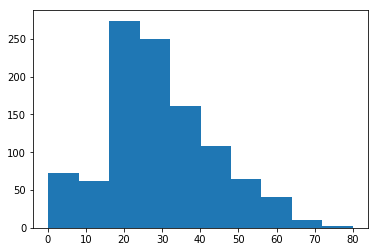

[  0.       51.23292 102.46584 153.69876 204.93168 256.1646  307.39752
 358.63044 409.86336 461.09628]


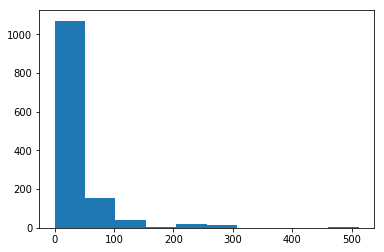

In [6]:
# return a separator to categorize a numerical field
def num2cat(num_feat, n_class=10):
    def to_float(x):
        if len(x):
            return float(x)
        else:
            return -1

    num_feat = np.array([to_float(x) for x in num_feat])
    min_val, max_val = num_feat[num_feat > -1].min(), num_feat.max()
    sep = np.linspace(min_val, max_val, n_class, endpoint=False)
    print(sep)
    plt.hist(num_feat[num_feat > -1], bins=n_class)
    plt.show()

    def indicator(x):
        x = to_float(x)
        if x == -1:
            return 0
        for i in range(len(sep)):
            if x < sep[i]:
                return i    
        return n_class

    return indicator


for nf in NUM_FEAT:
    ind = num2cat(list(train_feat[:, nf]) + list(test_feat[:, nf]))
    for _ in range(len(train_feat[nf])):
        train_feat[_, nf] = str(ind(train_feat[_, nf]))
    for _ in range(len(test_feat[nf])):
        test_feat[_, nf] = str(ind(test_feat[_, nf]))

In [7]:
train_feat = np.delete(train_feat, [1, 6, 8], axis=1)
test_feat = np.delete(test_feat, [1, 6, 8], axis=1)

print('train_feat:\n', train_feat)
print('test_feat:\n', test_feat)

train_feat:
 [['3' 'male' '3' ... '0' '1' 'S']
 ['1' 'female' '5' ... '0' '2' 'C']
 ['3' 'female' '4' ... '0' '1' 'S']
 ...
 ['3' 'female' '' ... '2' '23.45' 'S']
 ['1' 'male' '26' ... '0' '30' 'C']
 ['3' 'male' '32' ... '0' '7.75' 'Q']]
test_feat:
 [['3' 'male' '5' ... '0' '1' 'Q']
 ['3' 'female' '6' ... '0' '1' 'S']
 ['2' 'male' '8' ... '0' '1' 'Q']
 ...
 ['3' 'male' '38.5' ... '0' '7.25' 'S']
 ['3' 'male' '' ... '0' '8.05' 'S']
 ['3' 'male' '' ... '1' '22.3583' 'C']]


In [8]:
class Dataset:
    # build feature map for one-hot encoding
    @staticmethod
    def build_feat_map(cat_feats):
        feat_map = {}
        for i in range(cat_feats.shape[1]):
            for x in cat_feats[:, i]:
                feat_name = str(i) + ':' + x
                if feat_name not in feat_map:
                    feat_map[feat_name] = len(feat_map)

        return feat_map
    
    # one-hot encoding
    def feat2id(self, cat_feats):
        feat_ids = []
        for i in range(cat_feats.shape[1]):
            feat_ids.append([])
            for x in cat_feats[:, i]:
                feat_name = str(i) + ':' + x
                feat_ids[-1].append(self.feat_map[feat_name])
        return np.int32(feat_ids).transpose()
    
    # split validation set
    def split_train_valid(self):
        np.random.seed(123)
        rnd = np.random.random(len(self.train_label))
        self.train_ind = np.where(rnd < 0.8)[0]
        self.valid_ind = np.where(rnd >= 0.8)[0]

        def to_csr(data, dim=len(self.feat_map)):
            row = np.zeros_like(data) + np.expand_dims(np.arange(len(data)), 1)
            val = np.ones_like(data)
            return csr_matrix((val.flatten(), (row.flatten(), data.flatten())), shape=(len(data), dim))    
            
        self.train_data = (self.train_label[self.train_ind], to_csr(self.train_feat[self.train_ind]))
        self.valid_data = (self.train_label[self.valid_ind], to_csr(self.train_feat[self.valid_ind]))
        self.test_data = (np.zeros(len(self.test_feat), dtype=np.int32), to_csr(self.test_feat))
    
    def __init__(self):
        self.feat_map = self.build_feat_map(np.vstack([train_feat, test_feat]))

        self.train_id, self.test_id = train_id, test_id
        self.train_label = np.int32(train_label)
        self.train_feat, self.test_feat = self.feat2id(train_feat), self.feat2id(test_feat)

        print('train_feat:\n', self.train_feat)
        print('test_feat:\n', self.test_feat)

        self.split_train_valid()
        
Data = Dataset()

train_feat:
 [[  0   3   5 ... 112 120 402]
 [  1   4   6 ... 112 121 403]
 [  0   4   7 ... 112 120 402]
 ...
 [  0   4  17 ... 114 351 402]
 [  1   3  40 ... 112 329 403]
 [  0   3  41 ... 112 142 404]]
test_feat:
 [[  0   3   6 ... 112 120 404]
 [  0   4  89 ... 112 120 402]
 [  2   3  23 ... 112 120 404]
 ...
 [  0   3 104 ... 112 181 402]
 [  0   3  17 ... 112 124 402]
 [  0   3  17 ... 113 194 403]]


In [9]:
# csr_matrix: https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html

print('train_label:\n', Data.train_data[0])
print('train_feat:\n', Data.train_data[1])

train_label:
 [0 1 1 1 0 0 0 1 1 1 1 0 0 0 1 0 1 0 1 0 1 1 0 1 0 0 1 0 0 1 1 0 0 0 1 1 0
 0 0 1 0 0 0 0 0 1 1 0 1 1 0 0 0 1 0 0 1 1 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0
 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0
 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 0 1 0 1 1 1 1 0 0 1 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 1 1 0 0 1
 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 1 1
 1 0 1 1 0 1 1 0 0 0 1 0 0 1 0 0 1 1 0 0 1 1 1 1 0 1 0 1 1 0 1 1 1 0 0 0 1
 1 1 0 0 1 0 1 0 1 1 0 1 0 0 1 1 0 0 0 0 1 1 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0
 0 1 1 1 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 1 1 1 1 0 0 0 0 1 0 0 0 0 1 0 0
 0 0 0 1 0 1 1 0 0 0 0 1 0 1 1 1 1 0 0 1 1 0 0 1 0 1 1 1 1 1 0 0 1 1 0 1 1
 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 1
 1 1 1 0 0 1 1 0 1 0 1 0 0 1 0 0 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 0 1 1 0 1 0
 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1
 0 0 1 1 0 

In [10]:
NID = {}


class Node:
    def __init__(self, feat_id=-1):
        self.feat_id = feat_id
        self.nid = len(NID)
        # if self.nid > 1000:
        #     exit(0)
        NID[self.nid] = self
        self.t_child = None
        self.f_child = None
        self._class = -1
        

class DecisionTree:
    def __init__(self, n_feat, max_depth=6, verbose=True):
        self.n_feat = n_feat
        self.max_depth = max_depth
        self.verbose = verbose
        self.root_node = Node()

    # TODO: implement gini index
    @staticmethod
    def entropy(labels):
        p = np.sum(labels) / len(labels)
        if p == 0 or p == 1:
            return 0
        return - p * np.log(p) - (1-p) * np.log(1-p)

    # TODO: min_samples_split 
    def fit(self, labels, data, cur_node=None, cur_depth=1):
        if cur_node is None:
            cur_node = self.root_node

        if self.verbose:
            print(cur_node.nid)
        
        """
        if current node is pure:
            set cur_node.label
            set null cur_node.t_child, cur_node.f_child
        else if current node reaches max_depth:
            set cur_node.label via majority vote
            set null cur_node.t_child, cur_node.f_child
        else:
            best_split = -1
            best_info_gain = -1
            for feature in feature_set:
                t_subset = {data | feature is True}
                f_subset = {data | feature is False}
                compute info_gain
                update best_info_gain, best_split
            
            # an exception
            
            cur_node.feat_id = best_split
            cur_node.t_child = Node()
            cur_node.f_child = Node()
            
            fit(t_subset, cur_node.t_child, cur_depth + 1)
            fit(t_subset, cur_node.f_child, cur_depth + 1)
        """

    def predict(self, data):
        assert data.ndim == 1
        cur_node = self.root_node
        feat_set = set(data)

        while True:
            if cur_node.t_child is None or cur_node.f_child is None:
                return cur_node._class
            if cur_node.feat_id in feat_set:
                cur_node = cur_node.t_child
            else:
                cur_node = cur_node.f_child

    def batch_predict(self, data):
        preds = []
        for i in range(data.shape[0]):
            preds.append(self.predict(data[i].tocoo().col))
        return np.array(preds)

    def acc(self, labels, data):
        preds = self.batch_predict(data)
        acc = np.int32(labels == preds).sum() / len(labels)
        return acc

DT = DecisionTree(len(Data.feat_map), max_depth=4, verbose=True)
DT.fit(*Data.train_data)

print(DT.acc(*Data.train_data))
print(DT.acc(*Data.valid_data))

0
0.0
0.0


In [11]:
from sklearn import tree

train_label, train_feat = Data.train_data[0], Data.train_data[1].toarray()
valid_label, valid_feat = Data.valid_data[0], Data.valid_data[1].toarray()

In [12]:
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=4)
clf.fit(train_feat, train_label)

train_preds = clf.predict(train_feat)
valid_preds = clf.predict(valid_feat)
print('train acc:', np.sum(train_preds == train_label) / len(train_label))
print('valid acc:', np.sum(valid_preds == valid_label) / len(valid_label))

from sklearn.externals.six import StringIO
import pydotplus

dot_data = StringIO()
tree.export_graphviz(clf,
                    out_file=dot_data,
                    feature_names=sorted(sorted(Data.feat_map.keys())),
                    class_names=['non-survival', 'survival'],
                    filled=True, rounded=True,
                    impurity=False)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_pdf('viz.pdf')

train acc: 0.8444130127298444
valid acc: 0.7989130434782609


True